In [17]:
from collections import defaultdict
import os
import pickle
import sys
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from scipy.cluster.hierarchy import fcluster, linkage, single
from scipy.spatial.distance import pdist

In [34]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pylab

In [38]:
B = nx.Graph()
## node list of bipartite 0
B.add_nodes_from(['A', 'B', 'C', 'D'], bipartite = 0)
## node list of bipartite 1
B.add_nodes_from([1,2,3], bipartite=1)

## add edges between them
B.add_edges_from([('A',1),('A',2), ('B',1), ('C',1), ('D',1),('D',2),('D',3)])

In [76]:
G = nx.Graph()
G.add_nodes_from(valid_cid_list, bipartite = 0)
G.add_nodes_from(valid_pid_list, bipartite = 1)
G.add_edges_from(valid_pair_list)

In [77]:
G_top = valid_cid_list
G_pos = nx.bipartite_layout(G, G_top)

In [78]:
color_map = []
for element in G:
    if element in G_top:
        color_map.append('red')
    else:
        color_map.append('green')

In [124]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(50, 50), dpi=120)
    plt.axis('off')
    fig = plt.figure(1)
    pos = G_pos
    #pos = B_pos
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(-1, xmax + 0.5)
    plt.ylim(-1, ymax+0.2)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

In [123]:
save_graph(B, 'my_graph.pdf')

In [125]:
save_graph(G,"my_graph.pdf")


In [29]:
plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

<Figure size 6400x4800 with 0 Axes>

<Figure size 6400x4800 with 0 Axes>

In [14]:
help(nx.draw_networkx)

Help on function draw_networkx in module networkx.drawing.nx_pylab:

draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
    Draw the graph G using Matplotlib.
    
    Draw the graph with Matplotlib with options for node positions,
    labeling, titles, and many other drawing features.
    See draw() for simple drawing without labels or axes.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    
    arrows : bool, optional (default=True)
       For directed graphs, if True draw arrowheads.
       Note: Arrows will be the same color as edges.
    
    arrowstyle : str, optional (default='-|>')
        For directed graphs, choose the style of the arrowsheads.
        See :py:class: `matplo

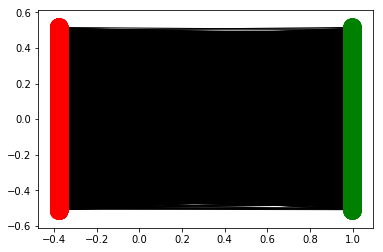

In [30]:
nx.draw_networkx(G, pos = G_pos, node_color = color_map, with_labels=False)

In [23]:
#Check if B is bipartite set
bipartite.is_bipartite(B)

True

In [39]:
set0 = bipartite.sets(B)[0]

In [40]:
top = nx.bipartite.sets(B)[0]

In [46]:
B_pos = nx.bipartite_layout(B,top)

In [42]:
color_map = []
for node in B:
    if node in set0:
        color_map.append('red')
    else:
        color_map.append('green')

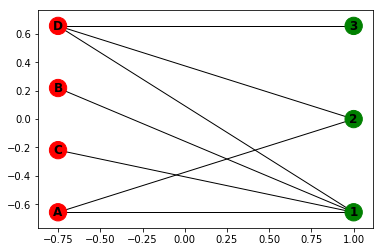

In [10]:
nx.draw_networkx(B, pos = pos, node_color = color_map, with_labels=True, font_weight = 'bold')

In [20]:
elem_list = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'W', 'Ru', 'Nb', 'Re', 'Te', 'Rh', 'Tc', 'Ba', 'Bi', 'Hf', 'Mo', 'U', 'Sm', 'Os', 'Ir', 'Ce','Gd','Ga','Cs', 'unknown']
aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
atom_fdim = len(elem_list) + 6 + 6 + 6 + 1
bond_fdim = 6
max_nb = 6


def onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def atom_features(atom):
    return np.array(onek_encoding_unk(atom.GetSymbol(), elem_list) 
            + onek_encoding_unk(atom.GetDegree(), [0,1,2,3,4,5]) 
            + onek_encoding_unk(atom.GetExplicitValence(), [1,2,3,4,5,6])
            + onek_encoding_unk(atom.GetImplicitValence(), [0,1,2,3,4,5])
            + [atom.GetIsAromatic()], dtype=np.float32)


def bond_features(bond):
    bt = bond.GetBondType()
    return np.array([bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE, bt == Chem.rdchem.BondType.TRIPLE, \
    bt == Chem.rdchem.BondType.AROMATIC, bond.GetIsConjugated(), bond.IsInRing()], dtype=np.float32)


def Mol2Graph(mol):
    # convert molecule to GNN input
    idxfunc=lambda x:x.GetIdx()

    n_atoms = mol.GetNumAtoms()
    assert mol.GetNumBonds() >= 0

    n_bonds = max(mol.GetNumBonds(), 1)
    fatoms = np.zeros((n_atoms,), dtype=np.int32) #atom feature ID
    fbonds = np.zeros((n_bonds,), dtype=np.int32) #bond feature ID
    atom_nb = np.zeros((n_atoms, max_nb), dtype=np.int32)
    bond_nb = np.zeros((n_atoms, max_nb), dtype=np.int32)
    num_nbs = np.zeros((n_atoms,), dtype=np.int32)
    num_nbs_mat = np.zeros((n_atoms,max_nb), dtype=np.int32)

    for atom in mol.GetAtoms():
        idx = idxfunc(atom)
        fatoms[idx] = atom_dict[''.join(str(x) for x in atom_features(atom).astype(int).tolist())] 

    for bond in mol.GetBonds():
        a1 = idxfunc(bond.GetBeginAtom())
        a2 = idxfunc(bond.GetEndAtom())
        idx = bond.GetIdx()
        fbonds[idx] = bond_dict[''.join(str(x) for x in bond_features(bond).astype(int).tolist())] 
        try:
            atom_nb[a1,num_nbs[a1]] = a2
            atom_nb[a2,num_nbs[a2]] = a1
        except:
            return [], [], [], [], []
        bond_nb[a1,num_nbs[a1]] = idx
        bond_nb[a2,num_nbs[a2]] = idx
        num_nbs[a1] += 1
        num_nbs[a2] += 1
        
    for i in range(len(num_nbs)):
        num_nbs_mat[i,:num_nbs[i]] = 1

    return fatoms, fbonds, atom_nb, bond_nb, num_nbs_mat


def Batch_Mol2Graph(mol_list):
    res = list(map(lambda x:Mol2Graph(x), mol_list))
    fatom_list, fbond_list, gatom_list, gbond_list, nb_list = zip(*res)
    return fatom_list, fbond_list, gatom_list, gbond_list, nb_list


def Protein2Sequence(sequence, ngram=1):
    # convert sequence to CNN input
    sequence = sequence.upper()
    word_list = [sequence[i:i+ngram] for i in range(len(sequence)-ngram+1)]
    output = []
    for word in word_list:
        if word not in aa_list:
            output.append(word_dict['X'])
        else:
            output.append(word_dict[word])
    if ngram == 3:
        output = [-1]+output+[-1] # pad
    return np.array(output, np.int32)


def Batch_Protein2Sequence(sequence_list, ngram=3):
    res = list(map(lambda x:Protein2Sequence(x,ngram), sequence_list))
    return res


def get_mol_dict():
    if os.path.exists('../data/mol_dict'):
        with open('../data/mol_dict') as f:
            mol_dict = pickle.load(f)
    else:
        mol_dict = {}
        mols = Chem.SDMolSupplier('../data/Components-pub.sdf')
        for m in mols:
            if m is None:
                continue
            name = m.GetProp("_Name")
            mol_dict[name] = m
        with open('../data/mol_dict', 'wb') as f:
            pickle.dump(mol_dict, f)
    #print('mol_dict',len(mol_dict))
    return mol_dict


def get_pairwise_label(pdbid, interaction_dict):
    if pdbid in interaction_dict:
        sdf_element = np.array([atom.GetSymbol().upper() for atom in mol.GetAtoms()])
        atom_element = np.array(interaction_dict[pdbid]['atom_element'], dtype=str)
        atom_name_list = np.array(interaction_dict[pdbid]['atom_name'], dtype=str)
        atom_interact = np.array(interaction_dict[pdbid]['atom_interact'], dtype=int)
        nonH_position = np.where(atom_element != ('H'))[0]
        assert sum(atom_element[nonH_position] != sdf_element) == 0
        
        atom_name_list = atom_name_list[nonH_position].tolist()
        pairwise_mat = np.zeros((len(nonH_position), len(interaction_dict[pdbid]['uniprot_seq'])), dtype=np.int32)
        for atom_name, bond_type in interaction_dict[pdbid]['atom_bond_type']:
            atom_idx = atom_name_list.index(str(atom_name))
            assert atom_idx < len(nonH_position)
            
            seq_idx_list = []
            for seq_idx, bond_type_seq in interaction_dict[pdbid]['residue_bond_type']:
                if bond_type == bond_type_seq:
                    seq_idx_list.append(seq_idx)
                    pairwise_mat[atom_idx, seq_idx] = 1
        if len(np.where(pairwise_mat != 0)[0]) != 0:
            pairwise_mask = True
            return True, pairwise_mat
    return False, np.zeros((1,1))


def get_fps(mol_list):
    fps = []
    for mol in mol_list:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024,useChirality=True)
        fps.append(fp)
    #print('fingerprint list',len(fps))
    return fps


def calculate_sims(fps1,fps2,simtype='tanimoto'):
    sim_mat = np.zeros((len(fps1),len(fps2))) #,dtype=np.float32)
    for i in range(len(fps1)):
        fp_i = fps1[i]
        if simtype == 'tanimoto':
            sims = DataStructs.BulkTanimotoSimilarity(fp_i,fps2)
        elif simtype == 'dice':
            sims = DataStructs.BulkDiceSimilarity(fp_i,fps2)
        sim_mat[i,:] = sims
    return sim_mat


def compound_clustering(ligand_list, mol_list):
    print 'start compound clustering...'
    fps = get_fps(mol_list)
    sim_mat = calculate_sims(fps, fps)
    #np.save('../preprocessing/'+MEASURE+'_compound_sim_mat.npy', sim_mat)
    print 'compound sim mat', sim_mat.shape
    C_dist = pdist(fps, 'jaccard')
    C_link = single(C_dist)
    for thre in [0.3, 0.4, 0.5, 0.6]:
        C_clusters = fcluster(C_link, thre, 'distance')
        len_list = []
        for i in range(1,max(C_clusters)+1):
            len_list.append(C_clusters.tolist().count(i))
        print 'thre', thre, 'total num of compounds', len(ligand_list), 'num of clusters', max(C_clusters), 'max length', max(len_list)
        C_cluster_dict = {ligand_list[i]:C_clusters[i] for i in range(len(ligand_list))}
        with open('../preprocessing/'+MEASURE+'_compound_cluster_dict_'+str(thre),'wb') as f:
            pickle.dump(C_cluster_dict, f, protocol=0)


def protein_clustering(protein_list, idx_list):
    print 'start protein clustering...'
    protein_sim_mat = np.load('../data/pdbbind_protein_sim_mat.npy').astype(np.float32)
    sim_mat = protein_sim_mat[idx_list, :]
    sim_mat = sim_mat[:, idx_list]
    print 'original protein sim_mat', protein_sim_mat.shape, 'subset sim_mat', sim_mat.shape
    #np.save('../preprocessing/'+MEASURE+'_protein_sim_mat.npy', sim_mat)
    P_dist = []
    for i in range(sim_mat.shape[0]):
        P_dist += (1-sim_mat[i,(i+1):]).tolist()
    P_dist = np.array(P_dist)
    P_link = single(P_dist)
    for thre in [0.3, 0.4, 0.5, 0.6]:
        P_clusters = fcluster(P_link, thre, 'distance')
        len_list = []
        for i in range(1,max(P_clusters)+1):
            len_list.append(P_clusters.tolist().count(i))
        print 'thre', thre, 'total num of proteins', len(protein_list), 'num of clusters', max(P_clusters), 'max length', max(len_list)
        P_cluster_dict = {protein_list[i]:P_clusters[i] for i in range(len(protein_list))}
        with open('../preprocessing/'+MEASURE+'_protein_cluster_dict_'+str(thre),'wb') as f:
            pickle.dump(P_cluster_dict, f, protocol=0)

def pickle_dump(dictionary, file_name):
    pickle.dump(dict(dictionary), open(file_name, 'wb'), protocol=0)

In [21]:
MEASURE = 'KIKD' # 'IC50' or 'KIKD'

In [22]:
mol_dict = get_mol_dict()
with open('../data/out7_final_pairwise_interaction_dict','rb') as f:
    interaction_dict = pickle.load(f)

wlnn_train_list = []
atom_dict = defaultdict(lambda: len(atom_dict))
bond_dict = defaultdict(lambda: len(bond_dict))
word_dict = defaultdict(lambda: len(word_dict))
for aa in aa_list:
    word_dict[aa]
word_dict['X']


20

In [23]:
i = 0
pair_info_dict = {}
f = open('../data/pdbbind_all_datafile.tsv')
print 'Step 2/5, generating labels...'
for line in f.readlines():
    i += 1
    if i % 1000 == 0:
        print 'processed sample num', i
    pdbid, pid, cid, inchi, seq, measure, label = line.strip().split('\t')
    # filter interaction type and invalid molecules
    if MEASURE == 'All':
        pass
    elif MEASURE == 'KIKD':
        if measure not in ['Ki', 'Kd']:
            continue
    elif measure != MEASURE:
        continue
    if cid not in mol_dict:
        print 'ligand not in mol_dict'
        continue
    mol = mol_dict[cid]
    
    # get labels
    value = float(label)
    pairwise_mask, pairwise_mat = get_pairwise_label(pdbid, interaction_dict)
    
    # handle the condition when multiple PDB entries have the same Uniprot ID and Inchi
    if inchi+' '+pid not in pair_info_dict:
        pair_info_dict[inchi+' '+pid] = [pdbid, cid, pid, value, mol, seq, pairwise_mask, pairwise_mat]
    else:
        if pair_info_dict[inchi+' '+pid][6]:
            if pairwise_mask and pair_info_dict[inchi+' '+pid][3] < value:
                pair_info_dict[inchi+' '+pid] = [pdbid, cid, pid, value, mol, seq, pairwise_mask, pairwise_mat]
        else:
            if pair_info_dict[inchi+' '+pid][3] < value:
                pair_info_dict[inchi+' '+pid] = [pdbid, cid, pid, value, mol, seq, pairwise_mask, pairwise_mat]
f.close()


Step 2/5, generating labels...
processed sample num 1000
processed sample num 2000
processed sample num 3000
processed sample num 4000
processed sample num 5000
processed sample num 6000
processed sample num 7000
processed sample num 8000
processed sample num 9000
processed sample num 10000
processed sample num 11000
processed sample num 12000
processed sample num 13000


In [24]:
valid_value_list = []
valid_cid_list = []
valid_pid_list = []
valid_pairwise_mask_list = []
valid_pairwise_mat_list = []
mol_inputs, seq_inputs = [], []

# get inputs
for item in pair_info_dict:
    pdbid, cid, pid, value, mol, seq, pairwise_mask, pairwise_mat = pair_info_dict[item]
    fa, fb, anb, bnb, nbs_mat = Mol2Graph(mol)
    if fa==[]:
        print 'num of neighbor > 6, ', cid
        continue
    mol_inputs.append([fa, fb, anb, bnb, nbs_mat])
    seq_inputs.append(Protein2Sequence(seq,ngram=1))
    valid_value_list.append(value)
    valid_cid_list.append(cid)
    valid_pid_list.append(pid)
    valid_pairwise_mask_list.append(pairwise_mask)
    valid_pairwise_mat_list.append(pairwise_mat)
    wlnn_train_list.append(pdbid)


/Users/leoseo/opt/anaconda3/envs/p2env/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


num of neighbor > 6,  84A
num of neighbor > 6,  B1R
num of neighbor > 6,  670
num of neighbor > 6,  B9F
num of neighbor > 6,  498
num of neighbor > 6,  067


In [25]:
valid_pair_list = []
for i in range(len(valid_cid_list)):
    pair = [valid_cid_list[i], valid_pid_list[i]]
    valid_pair_list.append(pair)


In [63]:
len(valid_pair_list)

6989

In [126]:
len(valid_cid_list)

6989

In [129]:
unique_cid_list = list(set(valid_cid_list))
unique_pid_list = list(set(valid_pid_list))

In [132]:
interaction_matrix = np.zeros((len(unique_cid_list), len(unique_pid_list)))

In [133]:
interaction_matrix.shape

(5535, 2079)

In [149]:
unique_cid_list.index(valid_pair_list[0][0])

1559

In [157]:
for i in range(len(valid_pair_list)):
    compound, protein = valid_pair_list[i]
    cid_ind = unique_cid_list.index(compound)
    pid_ind = unique_pid_list.index(protein)
    interaction_matrix[cid_ind, pid_ind] = 1

In [170]:
len(np.sum(interaction_matrix, 1))

5535

In [168]:
max(np.sum(interaction_matrix, 1))

56.0

In [169]:
max(np.sum(interaction_matrix, 0))

287.0

In [295]:
#compound-protein interaction number array
compound_int_num = np.sum(interaction_matrix, 1)
protein_int_num = np.sum(interaction_matrix, 0)

In [306]:
#make every np.float to np.int
compound_int_num = compound_int_num.astype(np.int64)
protein_int_num = protein_int_num.astype(np.int64)

In [ ]:
unique_cid_list[np.where(componund_int_num == 56)[0][0]]

In [339]:
def int_num_to_id(cid_or_pid, int_num):
    id_list = []
    if cid_or_pid == 'cid':
        arr = np.where(compound_int_num == int_num)[0]
        for i in range(len(arr)):
            cid = unique_cid_list[arr[i]]
            id_list.append(cid)
    elif cid_or_pid == 'pid':
        arr = np.where(protein_int_num == int_num)[0]
        for i in range(len(arr)):
            pid = unique_pid_list[arr[i]]
            id_list.append(pid)
    else:
        print 'error'
    return id_list

In [354]:
def get_filtered_list(cid_or_pid, thre):
    if cid_or_pid == 'cid':
        filtered_list = [i for i in Extract(c_list) if i >= thre]
    elif cid_or_pid == 'pid':
        filtered_list = [i for i in Extract(p_list) if i >= thre]
    else:
        print 'error'
    return filtered_list


In [359]:
get_filtered_list('cid', 4)

[25, 41, 44, 56]

In [360]:
def get_filtered_id(cid_or_pid, thre):
    flist = get_filtered_list(cid_or_pid, thre)
    id_dict = {}
    for i in range(len(flist)):
        id_dict[flist[i]] = int_num_to_id(cid_or_pid, flist[i])
    return id_dict        

In [365]:
get_filtered_id('pid', 20)

{20: ['P68400', 'P9WPX7'],
 21: ['P04585'],
 22: ['P37231', 'Q04609', 'O96935'],
 23: ['Q08638',
  'O14757',
  'P11086',
  'P03372',
  'P9WIL5',
  'P29317',
  'P11838',
  'P11309'],
 25: ['Q15370'],
 26: ['O60674'],
 28: ['Q8WSF8', 'P39900'],
 29: ['P08709'],
 30: ['O14965', 'Q9Y233'],
 31: ['P24941', 'P28720'],
 33: ['P00800', 'P19491'],
 34: ['P61823'],
 35: ['P00533'],
 36: ['P03951'],
 37: ['P03369'],
 43: ['P02766', 'P03367', 'P00749'],
 44: ['P18031'],
 47: ['Q16539'],
 55: ['P00489', 'P00811'],
 61: ['O60885'],
 62: ['P03366'],
 71: ['P07900', 'P56817'],
 83: ['P00742'],
 107: ['P00760'],
 128: ['P00734'],
 287: ['P00918']}

In [350]:
get_id_from_int_num('cid', 3)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 25, 41, 44, 56]

In [ ]:
for i in get_id_from_int_num('cid', 3):
    int_num_to_id('pid', )

In [311]:
unique_pid_list[np.where(protein_int_num == 287)[0][0]]

'P00918'

In [346]:
[i for i in Extract(c_list) if i >= 3]

int_num_to_id('cid', )

TypeError: int_num_to_id() takes exactly 2 arguments (1 given)

In [340]:
int_num_to_id('pid', 287)

['P00918']

In [285]:
compound_int_num[4407]

56

In [294]:
unique_cid_list[np.where(compound_int_num == 56)[0][0]]

'ADP'

In [254]:
unique_cid_list[4407]

'ADP'

In [173]:
np.argsort(compound_int_num)

array([   0, 3567, 3566, ..., 1169,  603, 4407])

In [177]:
compound_int_num[np.argsort(compound_int_num)]

array([ 1.,  1.,  1., ..., 41., 44., 56.])

In [187]:
protein_int_num[np.argsort(protein_int_num)][len(protein_int_num)-10:len(protein_int_num)]

array([ 55.,  55.,  61.,  62.,  71.,  71.,  83., 107., 128., 287.])

In [183]:
protein_int_num[np.argsort(protein_int_num)]

NameError: name 'index' is not defined

In [195]:
import matplotlib.pyplot as plt
from collections import Counter

In [243]:
p = Counter(protein_int_num)
c = Counter(compound_int_num)

In [244]:

c_list = []
p_list = []
for i in range(len(c.keys())):
    c_list.append([c.keys()[i],c.values()[i]])
    
p_list = []
for i in range(len(p.keys())):
    p_list.append([p.keys()[i],p.values()[i]])

In [246]:
for i in range(len(c_list)):
    c_list[i][0] = int(c_list[i][0])
c_list.sort()

In [327]:
def Extract(lst): 
    return [item[0] for item in lst]

In [328]:
Extract(c_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 25, 41, 44, 56]

In [344]:
[i for i in Extract(c_list) if i >= 3]

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 25, 41, 44, 56]

In [326]:
c_list

[[1, 4895],
 [2, 384],
 [3, 121],
 [4, 53],
 [5, 21],
 [6, 19],
 [7, 10],
 [8, 8],
 [9, 5],
 [10, 4],
 [11, 3],
 [12, 2],
 [13, 3],
 [15, 1],
 [17, 1],
 [19, 1],
 [25, 1],
 [41, 1],
 [44, 1],
 [56, 1]]

In [242]:
p_list

[[1, 1156],
 [2, 359],
 [3, 163],
 [4, 75],
 [5, 60],
 [6, 60],
 [7, 29],
 [8, 32],
 [9, 19],
 [10, 17],
 [11, 19],
 [12, 11],
 [13, 7],
 [14, 4],
 [15, 9],
 [16, 2],
 [17, 3],
 [18, 7],
 [19, 3],
 [20, 2],
 [21, 1],
 [22, 3],
 [23, 8],
 [25, 1],
 [26, 1],
 [28, 2],
 [29, 1],
 [30, 2],
 [31, 2],
 [33, 2],
 [34, 1],
 [35, 1],
 [36, 1],
 [37, 1],
 [43, 3],
 [44, 1],
 [47, 1],
 [55, 2],
 [61, 1],
 [62, 1],
 [71, 2],
 [83, 1],
 [107, 1],
 [128, 1],
 [287, 1]]

In [239]:
c_list.sort()

In [237]:
for i in range(len(c_list)):
    c_list[i][0] = int(c_list[i][0])
    

In [222]:
for i in range(len(c_keys)):
    c_keys[i] = int(c_keys[i])
    

In [233]:
c.keys()

[128.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 25.0,
 26.0,
 28.0,
 29.0,
 30.0,
 31.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 43.0,
 44.0,
 47.0,
 55.0,
 287.0,
 61.0,
 62.0,
 71.0,
 83.0,
 107.0]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 28,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 43,
 44,
 47,
 55,
 61,
 62,
 71,
 83,
 107,
 128,
 287]

In [194]:
dir(plt)

['Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Figure',
 'FigureCanvasBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotTool',
 'Text',
 'TickHelper',
 'Widget',
 '_INSTALL_FIG_OBSERVER',
 '_IP_REGISTERED',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 '_auto_draw_if_interactive',
 '_autogen_docstring',
 '_backend_mod',
 '_backend_selection',
 '_hold_msg',
 '_imread',
 '_imsave',
 '_interactive_bk',
 '_pylab_helpers',
 '_setp',
 '_setup_pyplot_info_docstrings',
 '_show',
 '_string_to_bool',
 'absolute_import',
 'acorr',
 'angle_spectrum',
 'annotate',
 